<a href="https://colab.research.google.com/github/ParekhJash1/Cancer-detection-through-image-using-CNN-and-Unet/blob/main/Road_extraction_using_UNET_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'deepglobe-road-extraction-dataset' dataset.


Epoch 1/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/125 [00:00<?, ?it/s]

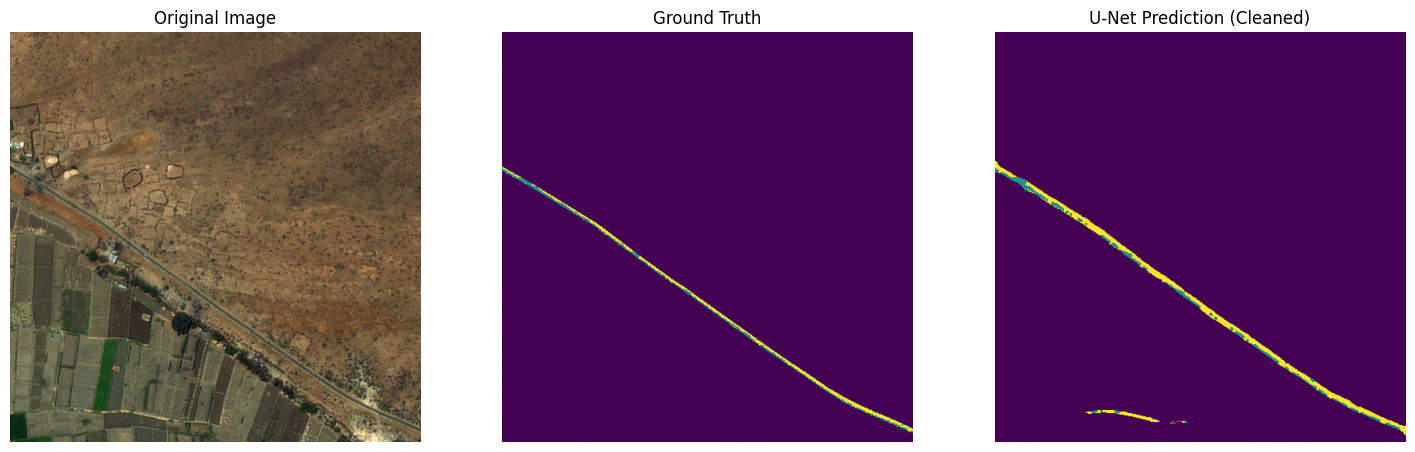

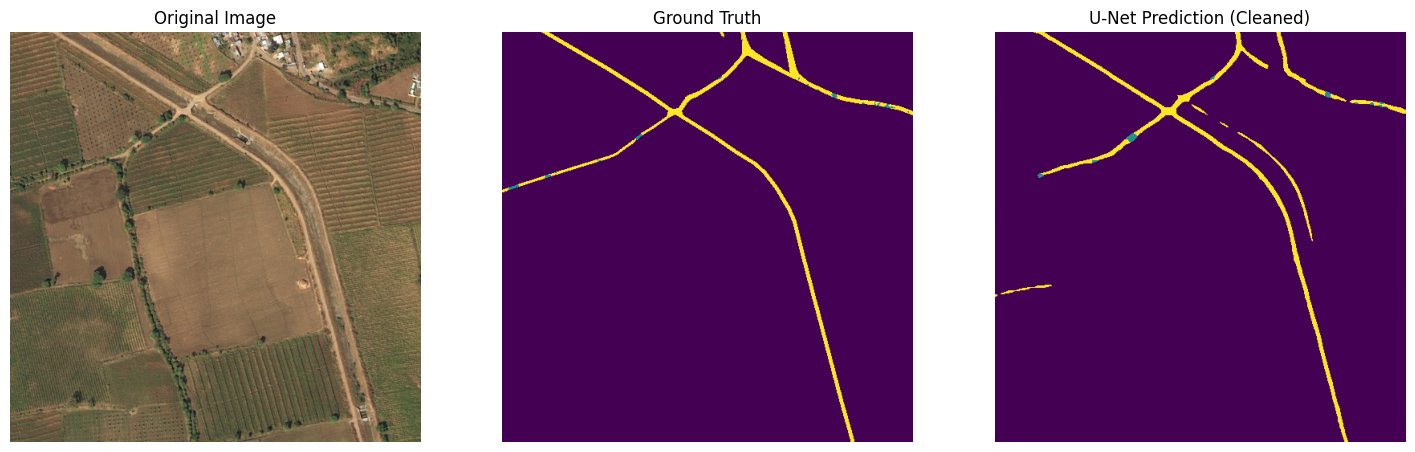

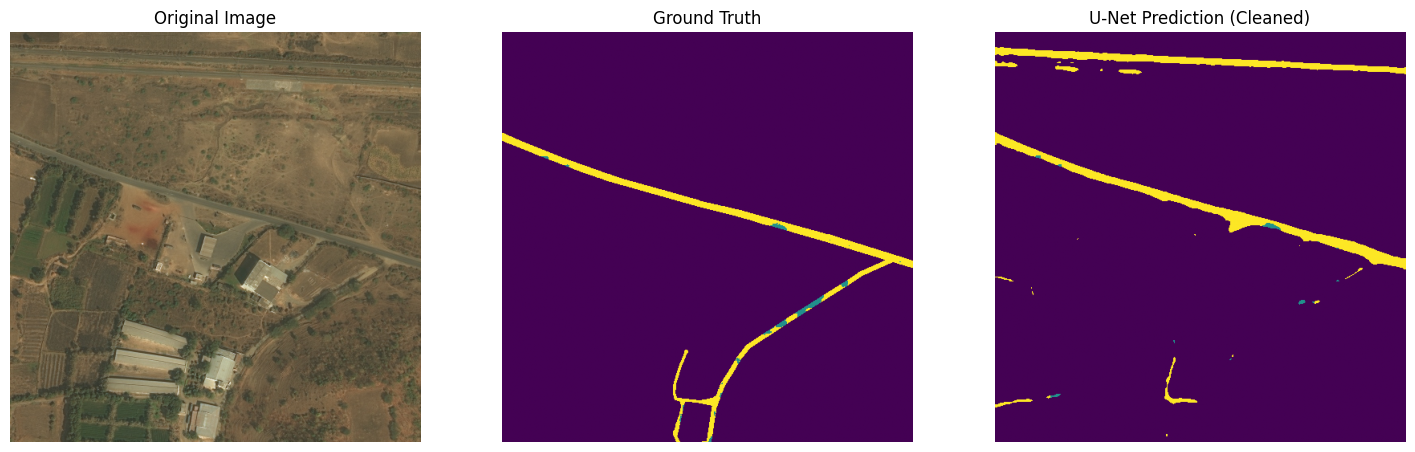

In [ ]:
import os, cv2, glob, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import kagglehub
from tqdm.notebook import tqdm

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 512
BATCH_SIZE = 8
EPOCHS = 15

# Download dataset
path = kagglehub.dataset_download("balraj98/deepglobe-road-extraction-dataset")
all_images = sorted(glob.glob(os.path.join(path, "train/*_sat.jpg")))
all_masks = sorted(glob.glob(os.path.join(path, "train/*_mask.png")))

# --- Model Components ---
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)



class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=3):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        s1 = self.enc1(x); p1 = self.pool(s1)
        s2 = self.enc2(p1); p2 = self.pool(s2)
        s3 = self.enc3(p2); p3 = self.pool(s3)
        s4 = self.enc4(p3); p4 = self.pool(s4)
        b = self.bottleneck(p4)
        x = self.dec4(torch.cat([self.up4(b), s4], dim=1))
        x = self.dec3(torch.cat([self.up3(x), s3], dim=1))
        x = self.dec2(torch.cat([self.up2(x), s2], dim=1))
        x = self.dec1(torch.cat([self.up1(x), s1], dim=1))
        return self.final(x)

# --- Dataset and Logic ---
def classify_road_type(img_rgb, bin_mask):
    mask = np.zeros_like(bin_mask)
    road_idx = bin_mask > 0
    road_pixels = img_rgb[road_idx]
    # Simple logic: earthy/reddish tones (Red > Blue + 20) are "Makeshift"
    is_makeshift = (road_pixels[:, 0].astype(int) - road_pixels[:, 2].astype(int)) > 20
    mask[road_idx] = np.where(is_makeshift, 2, 1) # 2:Makeshift, 1:Concrete
    return mask

class RoadDataset(Dataset):
    def __init__(self, imgs, masks, transform=None):
        self.imgs, self.masks, self.transform = imgs, masks, transform
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.imgs[idx]), cv2.COLOR_BGR2RGB)
        bin_m = (cv2.imread(self.masks[idx], 0) > 128).astype(np.uint8)
        mask = classify_road_type(img, bin_m)
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        return img, mask.long()

# Augmentations
tfs = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

# Use subset for training
ds = RoadDataset(all_images[:1000], all_masks[:1000], transform=tfs)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

# --- Loss and Training ---
def dice_loss(pred, target, num_classes=3, smooth=1e-6):
    pred = F.softmax(pred, dim=1)
    dice = 0
    for c in range(num_classes):
        p_c = pred[:, c]; t_c = (target == c).float()
        inter = (p_c * t_c).sum(dim=(1, 2))
        union = p_c.sum(dim=(1, 2)) + t_c.sum(dim=(1, 2))
        dice += (2. * inter + smooth) / (union + smooth)
    return 1 - dice.mean() / num_classes

model = UNet(out_ch=3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Weighting: [Background, Concrete, Makeshift]
# Giving more weight to roads helps because background pixels dominate the image.
weights = torch.tensor([1.0, 2.0, 2.0]).to(DEVICE)
ce_criterion = nn.CrossEntropyLoss(weight=weights)

def hybrid_loss(pred, target):
    return ce_criterion(pred, target) + dice_loss(pred, target)

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for imgs, msks in loop:
        imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)
        optimizer.zero_grad()
        loss = hybrid_loss(model(imgs), msks)
        loss.backward(); optimizer.step()
        loop.set_postfix(loss=loss.item())

# --- Visualization Function ---
def display_final_results(model, dataset, index=0, device='cuda'):
    model.eval()
    image, target = dataset[index]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Post-processing: Morphological Closing
    kernel = np.ones((3,3), np.uint8)
    clean_pred = cv2.morphologyEx(prediction.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    # Denormalize image
    img_disp = image.permute(1, 2, 0).cpu().numpy()
    img_disp = (img_disp * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_disp = np.clip(img_disp, 0, 1)

    # Colormap: Background (Purple), Concrete (Teal), Makeshift (Yellow)
    colors = np.array([[68, 1, 84], [33, 145, 140], [253, 231, 37]]) / 255.0
    target_rgb = colors[target.cpu().numpy()]
    pred_rgb = colors[clean_pred]

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1); plt.imshow(img_disp); plt.title("Original Image"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(target_rgb); plt.title("Ground Truth"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(pred_rgb); plt.title("U-Net Prediction (Cleaned)"); plt.axis('off')
    plt.show()

# Run visualization
indices_to_show = [10, 25, 50]
for idx in indices_to_show:
    if idx < len(ds):
        display_final_results(model, ds, index=idx, device=DEVICE)